In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
import numpy as np

import uproot
import awkward as ak
from coffea import nanoevents

from coffea.nanoevents.methods.base import NanoEventsArray
from coffea.analysis_tools import Weights, PackedSelection
from coffea.nanoevents.methods import nanoaod
from coffea.nanoevents.methods import vector
from coffea.lookup_tools.dense_lookup import dense_lookup

from HHbbVV.processors.utils import pad_val

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 24})

import warnings

warnings.filterwarnings("ignore")

In [2]:
from datetime import datetime
from pathlib import Path

MAIN_DIR = Path("../../../")
samples_dir = MAIN_DIR / "../data/skimmer/24Mar5AllYears"
# samples_dir = "/ceph/cms/store/user/annava/projects/HHbbVV/24Mar5AllYears"
year = "2016"

# date = "24Mar6"
date = datetime.now().strftime("%Y%m%d")
plot_dir = MAIN_DIR / f"plots/Kinematics/{date}/"
plot_dir.mkdir(parents=True, exist_ok=True)

Look at single SM VBF HH signal NanoAOD file

In [3]:
events = nanoevents.NanoEventsFactory.from_root(
    # "root://cmseos.fnal.gov///store/user/lpcpfnano/cmantill/v2_3/2018/HH/VBF_HHTobbVV_CV_1_C2V__C3_1_TuneCP5_13TeV-madgraph-pythia8/VBF_HHTobbVV_CV_1_C2V_1_C3_1/220808_150149/0000/nano_mc2018_1-1.root",
    "root://cmseos.fnal.gov///store/user/lpcpfnano/cmantill/v2_3/2018/HH/VBF_HHTobbVV_CV_1_C2V_0_C3_1_TuneCP5_13TeV-madgraph-pythia8/VBF_HHTobbVV_CV_1_C2V_0_C3_1/220808_150000/0000/nano_mc2018_1-1.root",
    schemaclass=nanoevents.NanoAODSchema,
).events()

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25
b_PDGID = 5
GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

Get generator-level Higgs and Vs

In [4]:
higgs = events.GenPart[
    (abs(events.GenPart.pdgId) == HIGGS_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)
]

higgs_children = higgs.children

# finding bb and VV children
is_bb = abs(higgs_children.pdgId) == b_PDGID
is_VV = (abs(higgs_children.pdgId) == W_PDGID) + (abs(higgs_children.pdgId) == Z_PDGID)

Hbb = higgs[ak.any(is_bb, axis=2)]
HVV = higgs[ak.any(is_VV, axis=2)]

# make sure we're only getting one Higgs
Hbb = ak.pad_none(Hbb, target=1, axis=1)[:, 0]
HVV = ak.pad_none(HVV, target=1, axis=1)[:, 0]

vs = events.GenPart[((abs(events.GenPart.pdgId) == W_PDGID)) * events.GenPart.hasFlags(GEN_FLAGS)]

# vbf output quarks are always at index 4, 5
gen_quarks = events.GenPart[events.GenPart.hasFlags(["isHardProcess"])][:, 4:6]

Matching efficiency calculation

In [5]:
def matching_efficiency(gen_quarks, vbf_jets, matching_dr=0.4, verbose=False):
    drs = ak.pad_none(vbf_jets, 2, axis=1)[:, :2].metric_table(gen_quarks)
    matched = drs < matching_dr
    # TODO: add overlap removal?
    matching_fraction = np.mean(np.all(np.any(matched, axis=2), axis=1))
    if verbose:
        print(f"Matching efficiency: {matching_fraction}")
    return matching_fraction

In [6]:
num_jets = 2

fatjets = events.FatJet

# particlenet xbb vs qcd

txbb = pad_val(
    fatjets.particleNetMD_Xbb / (fatjets.particleNetMD_QCD + fatjets.particleNetMD_Xbb),
    num_jets,
    axis=1,
)

# bb VV assignment

bb_mask = txbb[:, 0] >= txbb[:, 1]
bb_mask = np.stack((bb_mask, ~bb_mask)).T

Reproduce AK4 jet selections from skimmer

In [7]:
pt_choices = np.arange(0, 40, 0.5)
effs_pt = []
for pt in pt_choices:
    ak4_jet_selection = {  # noqa: RUF012
        "pt": pt,
        "eta": 2.7,
        "jetId": "tight",
        "puId": "medium",
        "dR_fatjetbb": 1.2,
        "dR_fatjetVV": 0.8,
    }

    # ak8 jet preselection
    preselection = {  # noqa: RUF012
        "pt": 300.0,
        "eta": 2.4,
        "VVmsd": 50,
        # "VVparticleNet_mass": [50, 250],
        # "bbparticleNet_mass": [92.5, 162.5],
        "bbparticleNet_mass": 50,
        "VVparticleNet_mass": 50,
        "bbFatJetParticleNetMD_Txbb": 0.8,
        "jetId": 2,  # tight ID bit
        "DijetMass": 800,  # TODO
        # "nGoodElectrons": 0,
    }

    num_jets = 2

    jets = events.Jet

    # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
    # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
    # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
    vbf_jet_mask = (
        jets.isTight
        & (jets.pt > ak4_jet_selection["pt"])
        & (np.abs(jets.eta) < 4.7)
        # medium puId https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetIDUL
        & ((jets.pt > 50) | ((jets.puId & 2) == 2))
        & (
            ak.all(
                jets.metric_table(
                    ak.singletons(ak.pad_none(fatjets, num_jets, axis=1, clip=True)[bb_mask])
                )
                > ak4_jet_selection["dR_fatjetbb"],
                axis=-1,
            )
        )
        & (
            ak.all(
                jets.metric_table(
                    ak.singletons(ak.pad_none(fatjets, num_jets, axis=1, clip=True)[~bb_mask])
                )
                > ak4_jet_selection["dR_fatjetVV"],
                axis=-1,
            )
        )
    )

    vbf_jets = jets[vbf_jet_mask]

    eff = matching_efficiency(gen_quarks, vbf_jets, matching_dr=0.4)
    effs_pt.append(eff)

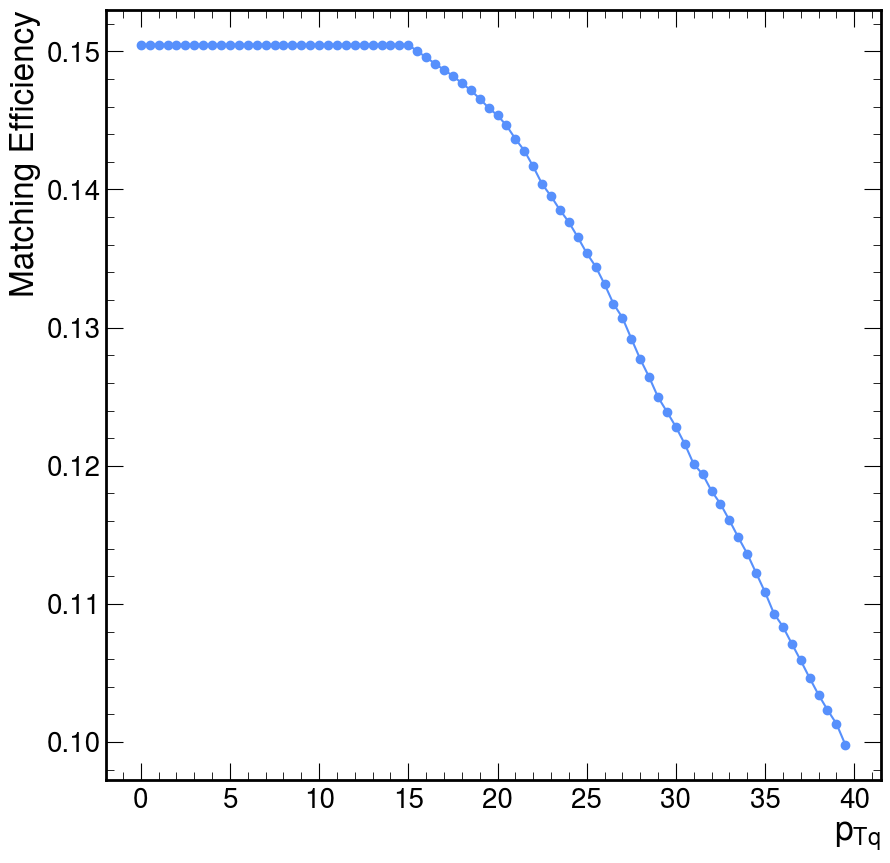

In [8]:
plt.plot(pt_choices, effs_pt, "o-")
plt.xlabel(r"$p_{Tq}$")
plt.ylabel("Matching Efficiency")
plt.savefig(plot_dir / "matching_efficiency_vs_pt.pdf", bbox_inches="tight")

In [9]:
eta_choices = np.arange(0, 10, 0.1)
effs_eta = []
for eta in eta_choices:
    ak4_jet_selection = {  # noqa: RUF012
        "pt": 25,
        "eta": 2.7,
        "jetId": "tight",
        "puId": "medium",
        "dR_fatjetbb": 1.2,
        "dR_fatjetVV": 0.8,
    }

    # ak8 jet preselection
    preselection = {  # noqa: RUF012
        "pt": 300.0,
        "eta": 2.4,
        "VVmsd": 50,
        # "VVparticleNet_mass": [50, 250],
        # "bbparticleNet_mass": [92.5, 162.5],
        "bbparticleNet_mass": 50,
        "VVparticleNet_mass": 50,
        "bbFatJetParticleNetMD_Txbb": 0.8,
        "jetId": 2,  # tight ID bit
        "DijetMass": 800,  # TODO
        # "nGoodElectrons": 0,
    }

    num_jets = 2

    jets = events.Jet

    # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
    # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
    # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
    vbf_jet_mask = (
        jets.isTight
        & (jets.pt > ak4_jet_selection["pt"])
        & (np.abs(jets.eta) < eta)
        # medium puId https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetIDUL
        & ((jets.pt > 50) | ((jets.puId & 2) == 2))
        & (
            ak.all(
                jets.metric_table(
                    ak.singletons(ak.pad_none(fatjets, num_jets, axis=1, clip=True)[bb_mask])
                )
                > ak4_jet_selection["dR_fatjetbb"],
                axis=-1,
            )
        )
        & (
            ak.all(
                jets.metric_table(
                    ak.singletons(ak.pad_none(fatjets, num_jets, axis=1, clip=True)[~bb_mask])
                )
                > ak4_jet_selection["dR_fatjetVV"],
                axis=-1,
            )
        )
    )

    vbf_jets = jets[vbf_jet_mask]

    eff = matching_efficiency(gen_quarks, vbf_jets, matching_dr=0.4)
    effs_eta.append(eff)

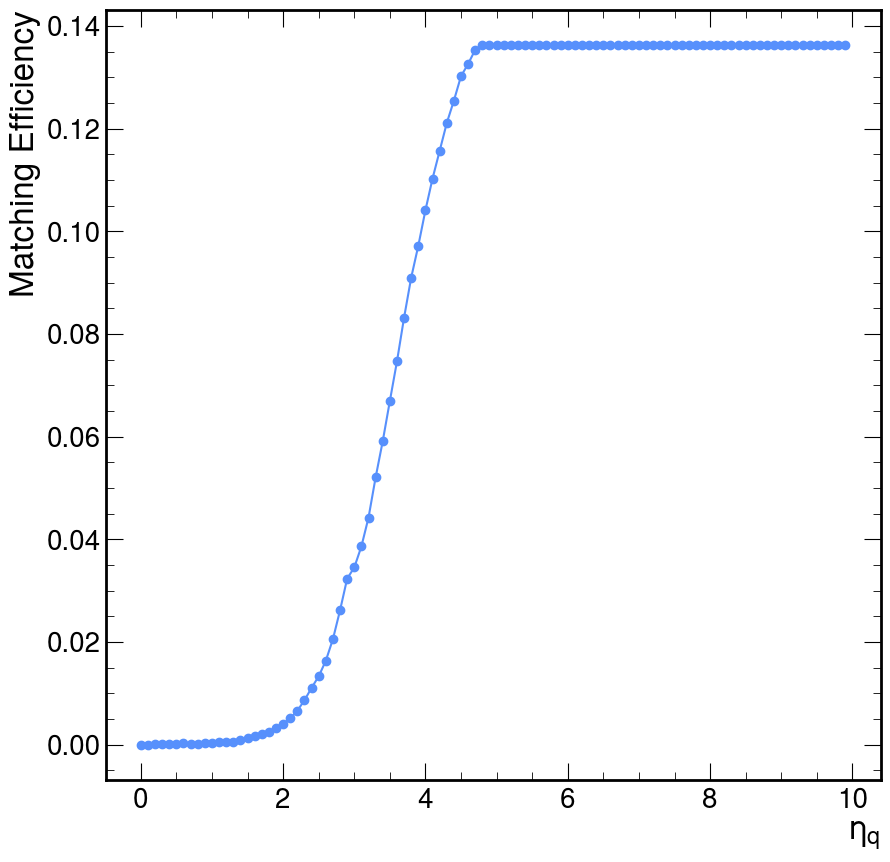

In [10]:
plt.plot(eta_choices, effs_eta, "o-")
plt.xlabel(r"$\eta_{q}$")
plt.ylabel("Matching Efficiency")
plt.savefig(plot_dir / "matching_efficiency_vs_etaq.pdf", bbox_inches="tight")

In [11]:
dR_fatjetbb_choices = np.arange(0, 8, 0.1)
effs_dR_fatjetbb = []
for dR_fatjetbb in dR_fatjetbb_choices:
    ak4_jet_selection = {  # noqa: RUF012
        "pt": 25,
        "eta": 2.7,
        "jetId": "tight",
        "puId": "medium",
        "dR_fatjetbb": dR_fatjetbb,
        "dR_fatjetVV": 0.8,
    }

    # ak8 jet preselection
    preselection = {  # noqa: RUF012
        "pt": 300.0,
        "eta": 2.4,
        "VVmsd": 50,
        # "VVparticleNet_mass": [50, 250],
        # "bbparticleNet_mass": [92.5, 162.5],
        "bbparticleNet_mass": 50,
        "VVparticleNet_mass": 50,
        "bbFatJetParticleNetMD_Txbb": 0.8,
        "jetId": 2,  # tight ID bit
        "DijetMass": 800,  # TODO
        # "nGoodElectrons": 0,
    }

    num_jets = 2

    jets = events.Jet

    # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
    # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
    # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
    vbf_jet_mask = (
        jets.isTight
        & (jets.pt > ak4_jet_selection["pt"])
        & (np.abs(jets.eta) < 4.7)
        # medium puId https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetIDUL
        & ((jets.pt > 50) | ((jets.puId & 2) == 2))
        & (
            ak.all(
                jets.metric_table(
                    ak.singletons(ak.pad_none(fatjets, num_jets, axis=1, clip=True)[bb_mask])
                )
                > ak4_jet_selection["dR_fatjetbb"],
                axis=-1,
            )
        )
        & (
            ak.all(
                jets.metric_table(
                    ak.singletons(ak.pad_none(fatjets, num_jets, axis=1, clip=True)[~bb_mask])
                )
                > ak4_jet_selection["dR_fatjetVV"],
                axis=-1,
            )
        )
    )

    vbf_jets = jets[vbf_jet_mask]

    eff = matching_efficiency(gen_quarks, vbf_jets, matching_dr=0.4)
    effs_dR_fatjetbb.append(eff)

Max efficiency: 0.1353939393939394 at dR_fatjetbb = 1.2000000000000002


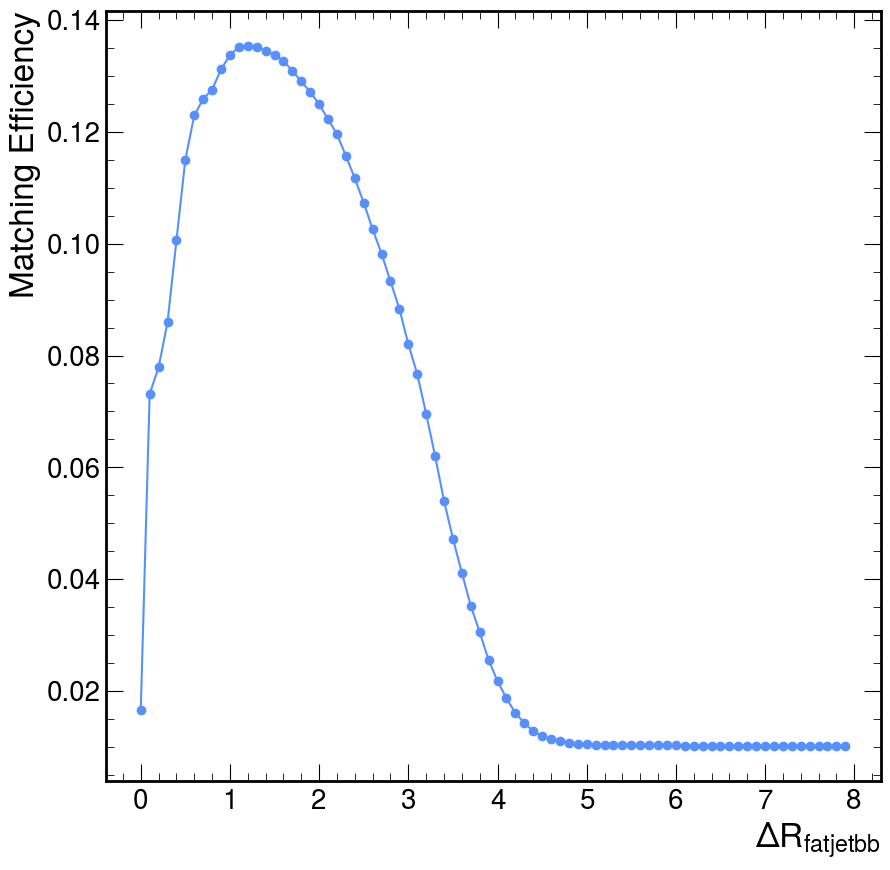

In [12]:
plt.plot(dR_fatjetbb_choices, effs_dR_fatjetbb, "o-")
plt.xlabel(r"$\Delta R_{fatjetbb}$")
plt.ylabel("Matching Efficiency")
# find max and argmax
dR_fatjetbb_choices_argmax = np.argmax(effs_dR_fatjetbb)
dr_fatjetbb_choices_max = dR_fatjetbb_choices[dR_fatjetbb_choices_argmax]
print(
    f"Max efficiency: {effs_dR_fatjetbb[dR_fatjetbb_choices_argmax]} at dR_fatjetbb = {dr_fatjetbb_choices_max}"
)
plt.savefig(plot_dir / "matching_efficiency_vs_dRfatjetbb.pdf", bbox_inches="tight")

In [13]:
dR_fatjetVV_choices = np.arange(0, 8, 0.1)
effs_dR_fatjetVV = []
for dR_fatjetVV in dR_fatjetVV_choices:
    ak4_jet_selection = {  # noqa: RUF012
        "pt": 25,
        "eta": 2.7,
        "jetId": "tight",
        "puId": "medium",
        "dR_fatjetbb": 1.2,
        "dR_fatjetVV": dR_fatjetVV,
    }

    # ak8 jet preselection
    preselection = {  # noqa: RUF012
        "pt": 300.0,
        "eta": 2.4,
        "VVmsd": 50,
        # "VVparticleNet_mass": [50, 250],
        # "bbparticleNet_mass": [92.5, 162.5],
        "bbparticleNet_mass": 50,
        "VVparticleNet_mass": 50,
        "bbFatJetParticleNetMD_Txbb": 0.8,
        "jetId": 2,  # tight ID bit
        "DijetMass": 800,  # TODO
        # "nGoodElectrons": 0,
    }

    num_jets = 2

    jets = events.Jet

    # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
    # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
    # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
    vbf_jet_mask = (
        jets.isTight
        & (jets.pt > ak4_jet_selection["pt"])
        & (np.abs(jets.eta) < 4.7)
        # medium puId https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetIDUL
        & ((jets.pt > 50) | ((jets.puId & 2) == 2))
        & (
            ak.all(
                jets.metric_table(
                    ak.singletons(ak.pad_none(fatjets, num_jets, axis=1, clip=True)[bb_mask])
                )
                > ak4_jet_selection["dR_fatjetbb"],
                axis=-1,
            )
        )
        & (
            ak.all(
                jets.metric_table(
                    ak.singletons(ak.pad_none(fatjets, num_jets, axis=1, clip=True)[~bb_mask])
                )
                > ak4_jet_selection["dR_fatjetVV"],
                axis=-1,
            )
        )
    )

    vbf_jets = jets[vbf_jet_mask]

    eff = matching_efficiency(gen_quarks, vbf_jets, matching_dr=0.4)
    effs_dR_fatjetVV.append(eff)

Max efficiency: 0.13912121212121212 at dR_fatjetVV = 1.1


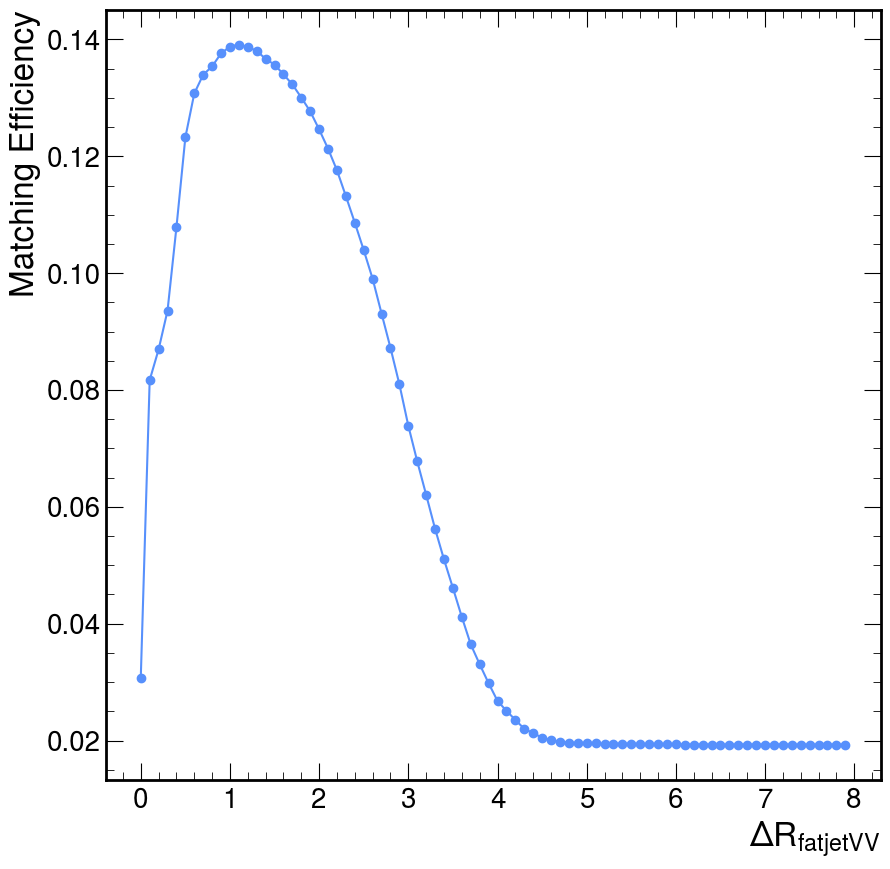

In [14]:
plt.plot(dR_fatjetVV_choices, effs_dR_fatjetVV, "o-")
plt.xlabel(r"$\Delta R_{fatjetVV}$")
plt.ylabel("Matching Efficiency")
# find max and argmax
dR_fatjetVV_choices_argmax = np.argmax(effs_dR_fatjetVV)
dr_fatjetVV_choices_max = dR_fatjetVV_choices[dR_fatjetVV_choices_argmax]
print(
    f"Max efficiency: {effs_dR_fatjetVV[dR_fatjetVV_choices_argmax]} at dR_fatjetVV = {dr_fatjetVV_choices_max}"
)
plt.savefig(plot_dir / "matching_efficiency_vs_dRfatjetVV.pdf", bbox_inches="tight")
plt.show()

In [15]:
ak4_jet_selection = {  # noqa: RUF012
    "pt": 25,
    "eta": 2.7,
    "jetId": "tight",
    "puId": "medium",
    "dR_fatjetbb": 1.2,
    "dR_fatjetVV": 1.1,
}

# ak8 jet preselection
preselection = {  # noqa: RUF012
    "pt": 300.0,
    "eta": 2.4,
    "VVmsd": 50,
    # "VVparticleNet_mass": [50, 250],
    # "bbparticleNet_mass": [92.5, 162.5],
    "bbparticleNet_mass": 50,
    "VVparticleNet_mass": 50,
    "bbFatJetParticleNetMD_Txbb": 0.8,
    "jetId": 2,  # tight ID bit
    "DijetMass": 800,  # TODO
    # "nGoodElectrons": 0,
}

num_jets = 2

fatjets = events.FatJet

# particlenet xbb vs qcd

txbb = pad_val(
    fatjets.particleNetMD_Xbb / (fatjets.particleNetMD_QCD + fatjets.particleNetMD_Xbb),
    num_jets,
    axis=1,
)

# bb VV assignment

bb_mask = txbb[:, 0] >= txbb[:, 1]
bb_mask = np.stack((bb_mask, ~bb_mask)).T

In [16]:
jets = events.Jet

# dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
# https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
# (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
vbf_jet_mask = (
    jets.isTight
    & (jets.pt > ak4_jet_selection["pt"])
    & (np.abs(jets.eta) < 4.7)
    # medium puId https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetIDUL
    & ((jets.pt > 50) | ((jets.puId & 2) == 2))
    & (
        ak.all(
            jets.metric_table(
                ak.singletons(ak.pad_none(fatjets, num_jets, axis=1, clip=True)[bb_mask])
            )
            > ak4_jet_selection["dR_fatjetbb"],
            axis=-1,
        )
    )
    & (
        ak.all(
            jets.metric_table(
                ak.singletons(ak.pad_none(fatjets, num_jets, axis=1, clip=True)[~bb_mask])
            )
            > ak4_jet_selection["dR_fatjetVV"],
            axis=-1,
        )
    )
)

vbf_jets = jets[vbf_jet_mask]

In [17]:
matching_efficiency(gen_quarks, vbf_jets, matching_dr=0.4)

0.13912121212121212

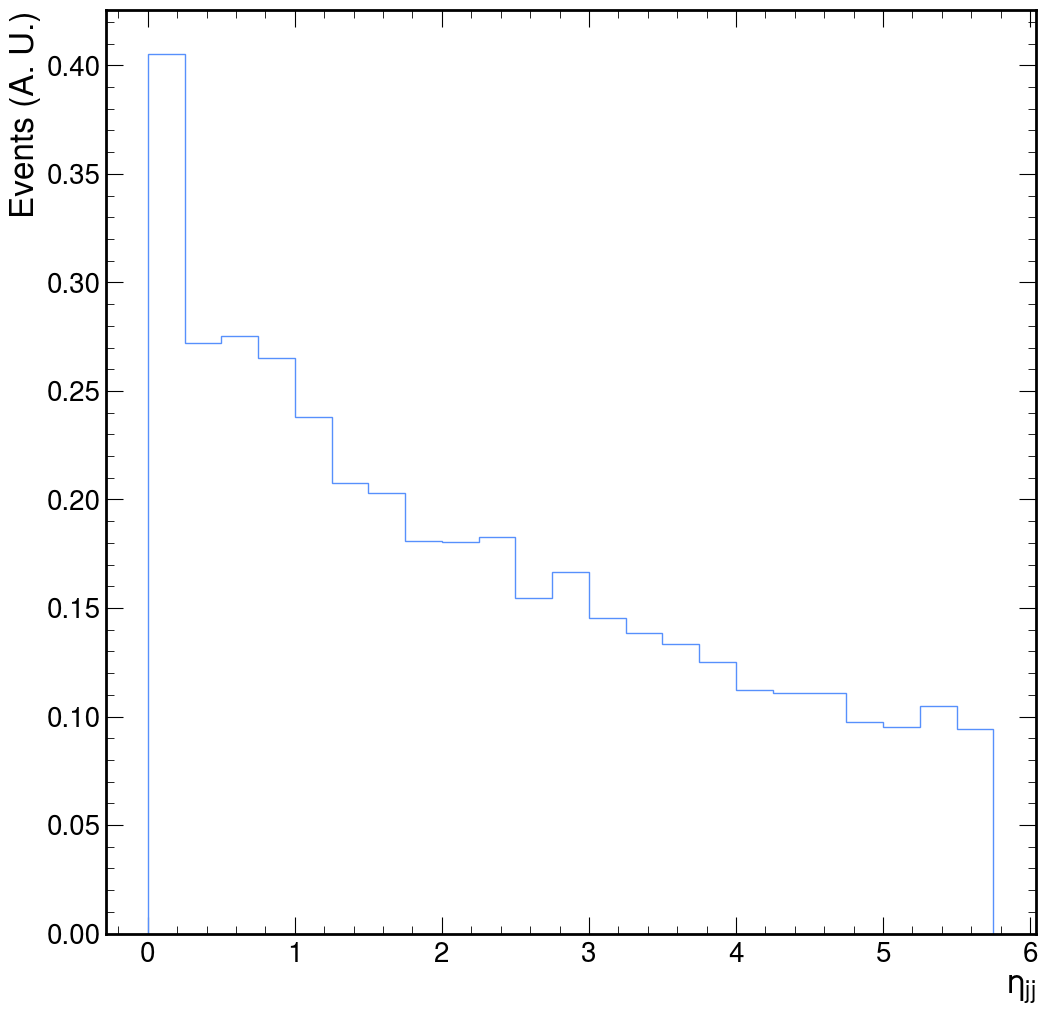

In [18]:
etas = pad_val(vbf_jets.eta, 2, axis=1)

plt.rcParams.update({"font.size": 24})
plt.figure(figsize=(12, 12))
plt.hist(np.abs(etas[:, 0] - etas[:, 1]), np.arange(0, 6, 0.25), histtype="step", density=True)
plt.xlabel(r"$\eta_{jj}$")
plt.ylabel("Events (A. U.)")
plt.savefig(plot_dir / "vbf_eta.pdf", bbox_inches="tight")
plt.show()